## 배치 경사 하강법을 이용하여 성능 향상

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [2]:
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        # 직선 방정식 계산
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err):
        m = len(x)
        # 가중치에 대한 평균 gradient 계산
        w_grad = np.dot(x.T, err) / m
        # 절편에 대한 평균 gradient 계산
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    # 활성화 함수
    def activation(self, z):
        # 시그모이드 계산
        a = 1 / (1 + np.exp(-z))
        return a
    
    # 훈련
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        # 타깃을 열 벡터로 바꾸기
        y = y.reshape(-1, 1)
        # 검증용 타깃을 열 벡터로 바꾸기
        y_val = y_val.reshape(-1, 1)
        # 샘플 개수 저장
        m = len(x)
        # 가중치 초기화
        self.w = np.ones((x.shape[1], 1))
        # 절편 초기화
        self.b = 0
        # 가중치 기록
        self.w_history.append(self.w.copy())
        # epoch만큼 반복
        for i in range(epochs):
            # 정방향 계산 수행
            z = self.forpass(x)
            # 활성화 함수 적용
            a = self.activation(z)
            # 오차 계산
            err = -(y - a)
            # 오차를 역전파하여 gradient 계산
            w_grad, b_grad = self.backprop(x, err)
            # gradient에서 페널티 항의 미분값 더하기
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편 업데이트
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치 기록
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위한 클리핑
            a = np.clip(a, 1e-10, 1 - 1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)    

    # 예측
    def predict(self, x):
        # 정방향 계산
        z = self.forpass(x)
        # 스텝 함수 적용
        return z > 0
    
    # 정확도 계산
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    # 로지스틱 손실 함수 계산에 페널티 항 추가
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w ** 2)
    
    # 검증 세트 손실 계산
    def update_val_loss(self, x_val, y_val):
        # 정방향 계산
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        val_loss = np.sum(-(y_val * np.log(a)) + (1 - y_val) * np.log(1 - a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [4]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

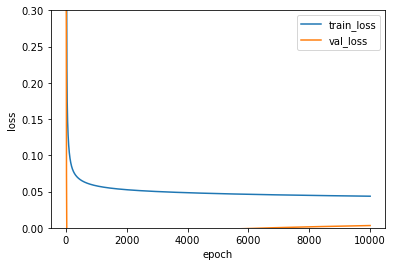

In [5]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

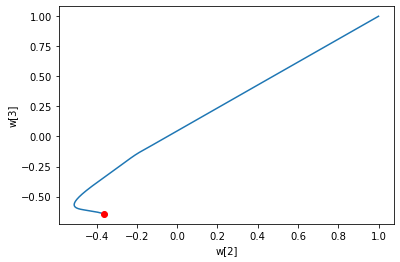

In [6]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()